In [1]:
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

# 加载CLIP模型和处理器
model = CLIPModel.from_pretrained("/mnt/workspace/ai/models/clip-vit-base/")
processor = CLIPProcessor.from_pretrained("/mnt/workspace/ai/models/clip-vit-base/")
print("加载模型完毕！")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


加载模型完毕！


In [2]:
import os

file_list = []
def load_images_recursive(directories):
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}
    images = []
    
    for dir_path in directories:
        for root, _, files in os.walk(dir_path):
            for filename in files:
                ext = os.path.splitext(filename)[1].lower()
                if ext in image_extensions:
                    file_path = os.path.join(root, filename)
                    try:
                        img = Image.open(file_path).convert("RGB")
                        images.append(img)
                        file_list.append(file_path)
                    except:
                        print(f"损坏文件: {file_path}")
    return images

# 图片目录
directories = ['/mnt/workspace/ai/datasets/cat', '/mnt/workspace/ai/datasets/dog']

# 获取所有图片内容
images = load_images_recursive(directories)

# 预处理并批处理图片
image_inputs = processor(images=images, return_tensors="pt")

# 提取特征
with torch.no_grad():
    image_features = model.get_image_features(**image_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)  # 归一化（可选但推荐）

# 输出形状示例：torch.Size([n_images, 512])
print("特征向量形状:", image_features.shape)

特征向量形状: torch.Size([40, 512])


要搜索的图片：


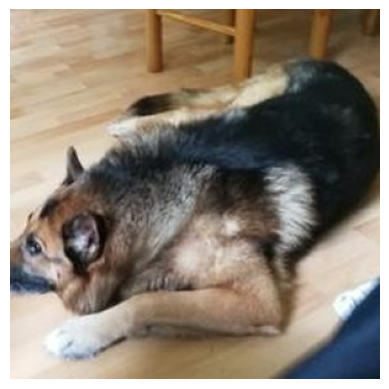

特征向量形状: torch.Size([1, 512])
搜索结果：Top 5 files based on given indices:
索引: 32 -> 图片: /mnt/workspace/ai/datasets/dog/ca-conf-0.19723114-t-1692474381472.jpg


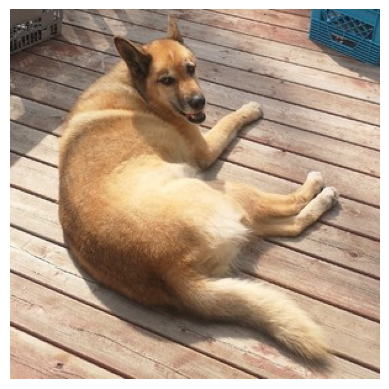

索引: 26 -> 图片: /mnt/workspace/ai/datasets/dog/be-conf-0.42062336-t-1687097605007.jpg


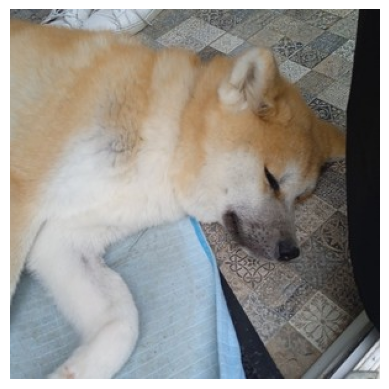

索引: 35 -> 图片: /mnt/workspace/ai/datasets/dog/ch-conf-0.30429807-t-1690902674174.jpg


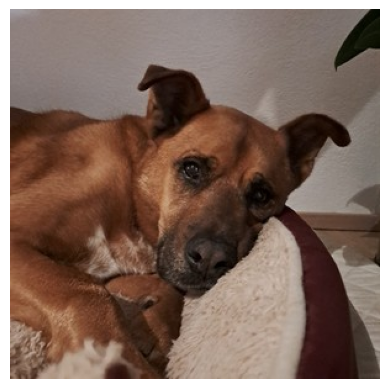

索引: 30 -> 图片: /mnt/workspace/ai/datasets/dog/br-conf-0.19696245-t-1688994487538.jpg


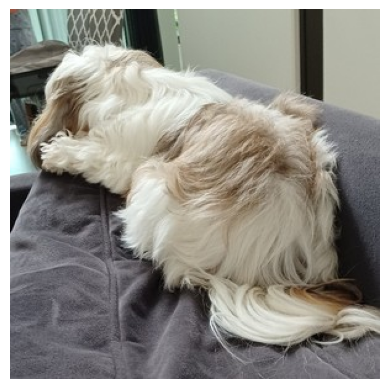

索引: 14 -> 图片: /mnt/workspace/ai/datasets/cat/ar-conf-0.94007635-t-1690999289202.jpg


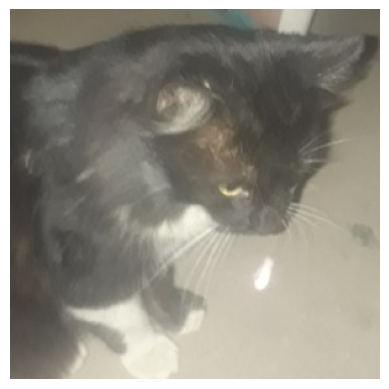

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

def get_random_files_glob(folder_path, num_files=5):
    """使用glob实现的版本（支持文件模式过滤）"""
    all_files = glob.glob(os.path.join(folder_path, "*"))
    all_files = [f for f in all_files if f.lower().endswith(('.jpg', '.png'))]
    return random.sample(all_files, min(num_files, len(all_files)))
    
# 使用图搜图
search_image = Image.open(get_random_files_glob("/mnt/workspace/ai/datasets/temp/validation/Dog/")[0]).convert("RGB")

# 处理图片以匹配模型输入格式
search_inputs = processor(images=search_image, return_tensors="pt")

# 提取特征
with torch.no_grad():
    search_features = model.get_image_features(**search_inputs)
    search_features /= search_features.norm(dim=-1, keepdim=True)  # 归一化（可选但推荐）

print("要搜索的图片：")
plt.imshow(search_image)
plt.axis('off')  # 关闭坐标轴
plt.show()
print("特征向量形状:", search_features.shape)

# 使用KNN邻近算法找到最近样本
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
knn.fit(image_features)
_, top_indices = knn.kneighbors(search_features)

print("搜索结果：Top 5 files based on given indices:")
for x in np.nditer(top_indices, order='F'):
    print(f"索引: {x} -> 图片: {file_list[x]}")
    plt.imshow(images[x])
    plt.axis('off')  # 关闭坐标轴
    plt.show()